<a href="https://colab.research.google.com/github/JJThoms1/05_transfer_learning_in_tensorflow_part_2_fine_tuning/blob/main/05_transfer_learning_in_tensorflow_part_2_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with Tensorflow Part 2: Fine-Tuning

In the previous notebook, we covered transfer learning feature extraction, now it's time to learn about a new kind of transfer learning: fine-tuning.

In [1]:
# Check if we're using a GPU
!nvidia-smi

Tue Oct 22 09:59:52 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Creating helper functions

In previous notebooks, we've created a bunch of helper functions, now we could rewrite them all, however, this would be tedious.

So, it's a good idea to put functions you'd like to use again in a script you can download and import into our notebooks (or elsewhere).

We've done this for some of the functions we've used perviously here: https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-10-22 09:59:53--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-10-22 09:59:54 (112 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Import helper functions we're going to use in this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

> 🔑 **Note:** If you're running this notebook in Google Colab, when it times our colab will delete `helper_functions.py` so you'll have to redownload it if you want to access your helper functions.

# Let's get some data

This time we're going to see how we can use the pretrained models within tf.keras.applications. And apply the toward our own problem (recognizing images of food).

link: https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [4]:
# Get 10% of training data of 10 classes of Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2024-10-22 09:59:59--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.175.207, 74.125.24.207, 142.251.10.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.175.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  20.3MB/s    in 9.0s    

2024-10-22 10:00:09 (17.9 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [5]:
# Check out how many images and subdirectories are in our database
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent

In [6]:
# Create training and test directory paths
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [7]:
import tensorflow as tf
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE,
                                                                            batch_size=BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [8]:
train_data_10_percent

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [9]:
# Check out the class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [10]:
# See an example of a batch of data
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[8.71479568e+01 7.85765305e+01 8.51479568e+01]
   [8.72244873e+01 8.15816345e+01 8.55816345e+01]
   [8.48673477e+01 8.35102081e+01 8.62959213e+01]
   ...
   [6.37296104e+01 8.04897461e+01 8.28571243e+01]
   [6.78316650e+01 7.79795761e+01 8.47142868e+01]
   [6.94132462e+01 7.38672562e+01 8.23825836e+01]]

  [[8.34795914e+01 8.19081573e+01 8.47653046e+01]
   [7.76326523e+01 7.77040787e+01 7.97040787e+01]
   [8.72295914e+01 8.67704086e+01 9.15153046e+01]
   ...
   [6.56581421e+01 7.94693451e+01 8.26275101e+01]
   [6.79846497e+01 8.28519974e+01 8.79183273e+01]
   [6.34541550e+01 8.15255814e+01 8.55255814e+01]]

  [[8.29030609e+01 8.84744873e+01 8.71173477e+01]
   [8.55918350e+01 8.89489746e+01 9.16224518e+01]
   [8.56887741e+01 8.63520432e+01 9.16887817e+01]
   ...
   [7.61428146e+01 8.10663757e+01 8.72347031e+01]
   [7.43876572e+01 8.60713730e+01 9.19999313e+01]
   [6.15867577e+01 8.00816803e+01 8.40816803e+01]]

  ...

  [[1.69005096e+02 1.90647980e+02 1.91433685e+02]
   [1

## Model 0: Building a transfer learning feature extraction model using the Keras Functional API

The squential API is straight-forward, it runs our layers in sequential order.

But the functional API gives us more flexibility with our models - https://www.tensorflow.org/guide/keras/functional_api

In [11]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the underlying pretrained patterns aren't updated during training)
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using a model like ResNet50V2 you will need to normalize inputs (you don't have to for EfficientNet(s))
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. Average pool the outputs of our base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# 10. Fit the model
history_10_percent = model_0.fit(train_data_10_percent,
                         epochs=5,
                         steps_per_epoch=len(train_data_10_percent),
                         validation_data=test_data,
                         validation_steps=int(0.25 * len(test_data)),
                         callbacks=[create_tensorboard_callback(dir_name="transfer learning",
                                                                experiment_name="10_percent_feature_extraction")])

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer learning/10_percent_feature_extraction/20241022-100018
Epoch 1/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 44s 839ms/step - accuracy: 0.2266 - loss: 2.1822 - val_accuracy: 0.6694 - val_loss: 1.3949
Epoch 2/5


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.6809 - val_loss: 1.4017
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 0.7246 - loss: 1.2942 - val_accuracy: 0.7599 - val_loss: 0.9940
Epoch 4/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7829 - val_loss: 0.9512
Epoch 5/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 291ms/step - accuracy: 0.7840 - loss: 0.9248 - val_accuracy: 0.8088 - val_loss: 0.8157


In [12]:
# Evaluate on the full test dataset
model_0.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - accuracy: 0.8060 - loss: 0.7946


[0.7943676114082336, 0.8004000186920166]

In [13]:
# Check the layers of our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_layer
1 rescaling
2 normalization
3 rescaling_1
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activati

In [14]:
# How about we get a summary of our base model
base_model.summary()

Model: "efficientnetb0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, None, None, 3)  │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, None, None, 3)  │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, None, None, 3)  │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, None, None, 3)  │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, None, None, 3)  │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, None, None, 32) │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, None, None, 32) │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, None, None, 32) │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, None, None, 32) │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, None, None, 32) │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, None, None, 32) │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 4,049,571 (15.45 MB)

In [15]:
# How about a summary of our whole model
model_0.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling_layer         │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 10)                  │          12,810 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,088,003 (15.59 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

 Optimizer params: 25,622 (100.09 KB)

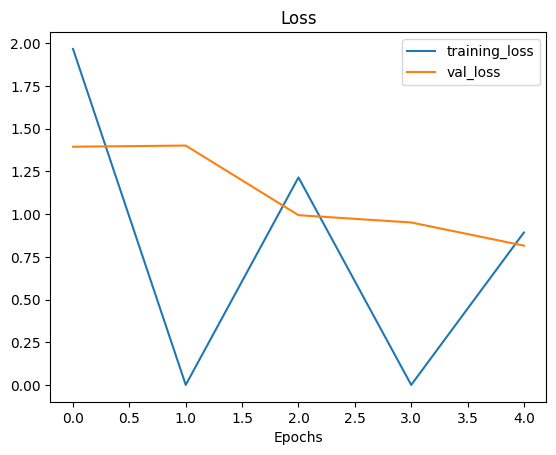

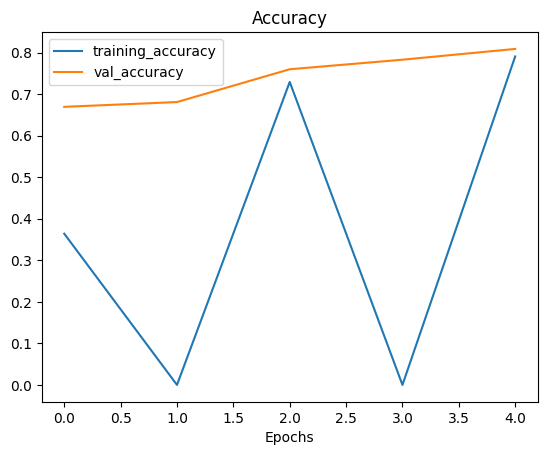

In [16]:
# Check out our models training curves
plot_loss_curves(history_10_percent)

## Getting a feature vector from a trained model

Let's demponstrate the Global Average Pooling 2D Layer...

We have a tensor after our model goes through a `base_model` of shape (None, 7, 7, 1280)...

But the when it passes through GlobalAveragePooling2D, it turns into (None, 1280).

Let's use a similar shaped tensor of (1, 4, 4, 3) and then pass it to GlobalAveragePooling2D.

In [17]:
# Define the input shape
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

# Pass the input tensor through a GlobalAveragePooling2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}\n")

# Check the shape of the different tensors
print(f"Shape of the input tensor: {input_tensor.shape}")
print(f"Shape of the global average pooled 2D tensor: {global_average_pooled_tensor.shape}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338894  0.97772694]
   [ 0.24694404  0.20573746 -0.52562326]
   [ 0.32410017  0.02545409 -0.10638496]
   [-0.63694745  1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815628  0.23479679 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of the input tensor: (1, 4, 4, 3)
Shape of the global average pooled 2D tensor: (1, 3)


In [18]:
# Let's replicate the GlobalAveragePool2D layer
tf.reduce_mean(input_tensor, axis=[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

🔑 **Note:** One of the reason feature extraction transfer learning is how it is, is because what often happens is pretrained model outputs a **feature vector** (a long tensor of numbers which represents the learned representations of the model on a particular sample, in our case, this is the output of the `tf.keras.layer.GlobalAveragePooling2D() layer`) which can then be used to extract patterns out of our own specific problem.

## Running a series of transfer learning experiments

We've seen the incredible results transfer learning can get with only 10% of the training data, but how does it work with 1% of the training data... how about we set up a bunch of experiments to find out.

1. `model_1` - use feature extraction transfer learning with 1% of the training data with data augmentation.
2. `model_2` - use feature extraction transfer learning with 10% of the training data with data augmentation.
3. `model_3` - use fine-tuning transfer learning on 10% of the training data with data augmentation.
4. `model_4` - use fine-tuning transfer learning on 100% of the training data with data augmentation.

🔑 **Note:** Througout all experiments the same test dataset will be exaluated our model... this ensures consistency across evaluation metrics.

### Getting and preprocessing data from model_1

In [19]:
# Download and unzip data - preprocessed from Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

--2024-10-22 10:01:22--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.175.207, 74.125.24.207, 142.251.10.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.175.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M  23.0MB/s    in 6.7s    

2024-10-22 10:01:29 (19.0 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [20]:
# Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train/"
test_dir_1_percent = "10_food_classes_1_percent/test/"

In [21]:
# How many images are we working with?
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There a

In [22]:
# Set up data loaders
IMG_SIZE = (224, 224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                          label_mode="categorical",
                                                                          image_size=IMG_SIZE,
                                                                          batch_size=BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                 label_mode="categorical",
                                                                 image_size=IMG_SIZE,
                                                                 batch_size=BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation right into the model

To add data augmentation right into our models, we can use the layers inside:

* `tf.keras.layers.experimental.preprocessing.RandomFlip()`
* `tf.keras.layers.experimental.preprocessing.RandomHeight()`
* `tf.keras.layers.experimental.preprocessing.RandomWidth()`

We can see the benefits of doing this within the TensorFlow Data Augmentation documentation: https://www.tensorflow.org/tutorials/images/data_augmentation

Off the top of our heads, after reading the docs, the benefits of using data augmentation inside the model are:
* Preprocessing of images (augmenting them) happens on the GPU (much faster) rather than the CPU.
* Image data augmentation only happens during training, so we can still export our whole model and use it elsewhere.

In [23]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import preprocessing
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomHeight, RandomWidth

# Create data augmentation stage with horizontal flipping, rotations, zooms, etc...
data_augmentation = keras.Sequential([
  RandomFlip("horizontal"),
  RandomRotation(0.2),
  RandomZoom(0.2),
  RandomHeight(0.2),
  RandomWidth(0.2),
  # preprocessing.Rescaling(1./255), # Keep for models like ResNet50V2 but EfficientNet's having Rescaling built-in.
], name="data_augmentation")

### Visualize our data augmentation layer (and see what happens to our data)

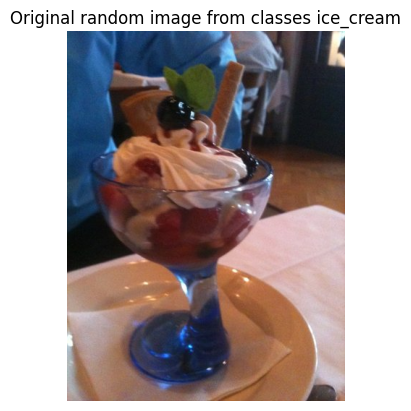

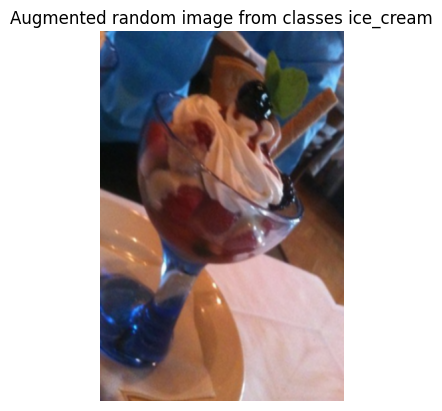

In [24]:
# View a random image and compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = os.path.join(target_dir, random.choice(os.listdir(target_dir)))

# Read and plot in the random image
img = mpimg.imread(random_image)
plt.imshow(img)
plt.title(f"Original random image from classes {target_class}")
plt.axis(False);

# Now let's plot our augmented random image
img = tf.expand_dims(img, axis=0)
# Apply data augmentation
augmented_img = data_augmentation(img, training=True)
# Remove the batch dimension for plotting
augmented_img = tf.squeeze(augmented_img, axis=0)

plt.figure()
plt.imshow(augmented_img.numpy().astype('uint8')) # Convert to numpy array and cast to uint8 for plotting with matplotlib.imshow
plt.title(f"Augmented random image from classes {target_class}")
plt.axis(False);

## Model 1: Feature extraction transfer learning on 1% of the data with data augmentation

In [25]:
# Setup the input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layers
input = layers.Input(shape=input_shape, name="input_layer")

# Resizing layer to match EfficientNetB0's input shape
x = tf.keras.layers.Resizing(384, 512)(input)

# Give base_model the inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool the output features of the base_model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on the as the output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model using the input and output
model_1 = keras.Model(input, outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_1_percent),
                                validation_data=test_data,
                                validation_steps=int(0.25 * len(test_data)),
                                callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                              experiment_name="1_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20241022-100134
Epoch 1/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 51s 10s/step - accuracy: 0.1164 - loss: 2.4186 - val_accuracy: 0.1694 - val_loss: 2.2386
Epoch 2/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 648ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.1464 - val_loss: 2.2751
Epoch 3/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.2237 - loss: 2.1726 - val_accuracy: 0.2780 - val_loss: 2.1368
Epoch 4/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 664ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.2697 - val_loss: 2.1421
Epoch 5/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 31s 15s/step - accuracy: 0.3921 - loss: 1.9853 - val_accuracy: 0.3235 - val_loss: 2.0870


In [26]:
# Check out out model summary
model_1.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resizing (Resizing)                  │ (None, 384, 512, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 12, 16, 1280)        │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling_layer         │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 10)                  │          12,810 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,088,003 (15.59 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

 Optimizer params: 25,622 (100.09 KB)

In [27]:
# Evaluate on the full test dataset
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 110ms/step - accuracy: 0.3398 - loss: 2.0525


[2.049152374267578, 0.3416000008583069]

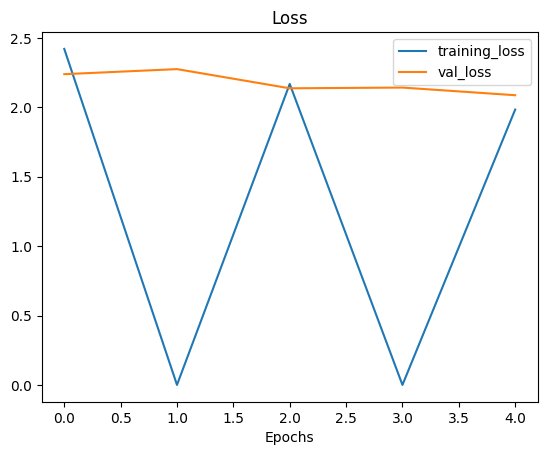

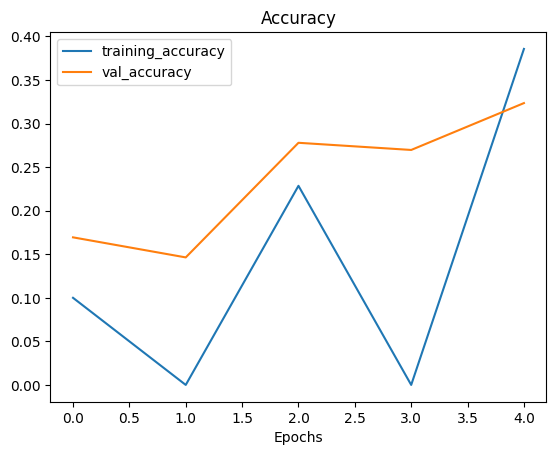

In [28]:
# How do the model with 1% of the data augmentation loss curves look?
plot_loss_curves(history_1_percent)

## Model 2: feature extraction transfer learning model with 10% of data and data augmentation

In [29]:
# Get 10% of data
train_dir_10_percent = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [30]:
# How many images are in our directory?
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent

In [31]:
# Set data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                 label_mode="categorical",
                                                                 image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [32]:
# Create model 2 with data augmentation built in
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import preprocessing
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomHeight, RandomWidth

# Build data augmentation
data_augmentation = keras.Sequential([
  RandomFlip("horizontal"),
  RandomRotation(0.2),
  RandomZoom(0.2),
  RandomHeight(0.2),
  RandomWidth(0.2)
  # Rescaling(1./255), # Keep for models like ResNet50V2 but EfficientNet's having Rescaling built-in.
], name="data_augmentation")

# Set up the input shape to our model
input_shape = (224, 224, 3)

# Create a frozen base model (also called a backbone)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create the inputs and outputs (including the layers in between)
inputs = layers.Input(shape=input_shape, name="input_layer")
x = data_augmentation(inputs) # augment our training images (augmentation doesn't occur on test data)
x = base_model(x, training=False) # pass the augmented images to the base model but keep the base model in inference mode, this also insures batchnorm layers dont't get updated: https://keras.io/api/layers/normalization_layers/batch_normalization/
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Create the model
model_2 = keras.Model(inputs, outputs)

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [33]:
model_2.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ data_augmentation (Sequential)       │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, None, None, 1280)    │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling_layer         │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 10)                  │          12,810 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,062,381 (15.50 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [34]:
model_0.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling_layer         │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 10)                  │          12,810 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,088,003 (15.59 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

 Optimizer params: 25,622 (100.09 KB)

### Creating a ModelCheckpoint callback

The ModelCheckpoint callback intermediately saves our model (the full model or just the weights) during training. This is useful so we can come and start where we left off: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint

In [35]:
# Set checkpoint path
checkpoint_path = "ten_percent_model_checkpoint_weights/checkpoint.ckpt.weights.h5"

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                         save_freq="epoch", # save every epoch
                                                         verbose=1)

### Fit model 2 passing it the ModelCheckpoint callback

In [36]:
# Fit the model saving checkpoint every epoch
initial_epochs = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                           epochs=initial_epochs,
                                           steps_per_epoch=len(train_data_10_percent),
                                           validation_data=test_data,
                                           validation_steps=int(0.25 * len(test_data)),
                                           callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                  experiment_name="10_percent_data_aug"),
                                                      checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20241022-100403
Epoch 1/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.1938 - loss: 2.1984
Epoch 1: saving model to ten_percent_model_checkpoint_weights/checkpoint.ckpt.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 21s 357ms/step - accuracy: 0.1976 - loss: 2.1931 - val_accuracy: 0.5822 - val_loss: 1.6217
Epoch 2/5

Epoch 2: saving model to ten_percent_model_checkpoint_weights/checkpoint.ckpt.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5855 - val_loss: 1.5885
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.5940 - loss: 1.5171
Epoch 3: saving model to ten_percent_model_checkpoint_weights/checkpoint.ckpt.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 13s 240ms/step - accuracy: 0.5949 - loss: 1.5150 - val_accuracy: 0.7484 - val_loss: 1.1414
Epoch 4/5

Epoch 4: saving model to ten_percent_model_checkpoint_weights/checkpoint.ckpt.weights.h5
24/24

In [37]:
# What were model_0 results?
model_0.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.7955 - loss: 0.8050


[0.7943678498268127, 0.8004000186920166]

In [38]:
# Check model_2 results on all test_data
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 86ms/step - accuracy: 0.7618 - loss: 0.9707


[0.9568334221839905, 0.7644000053405762]

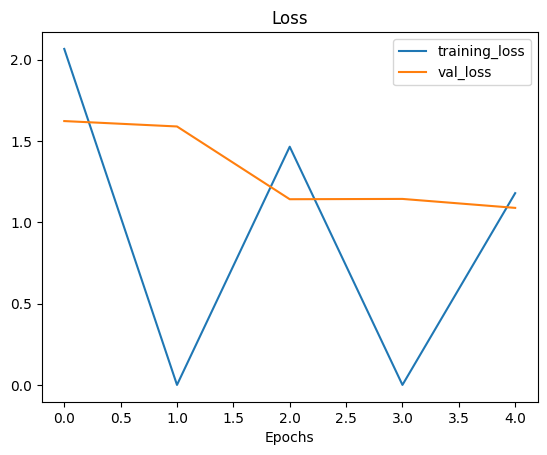

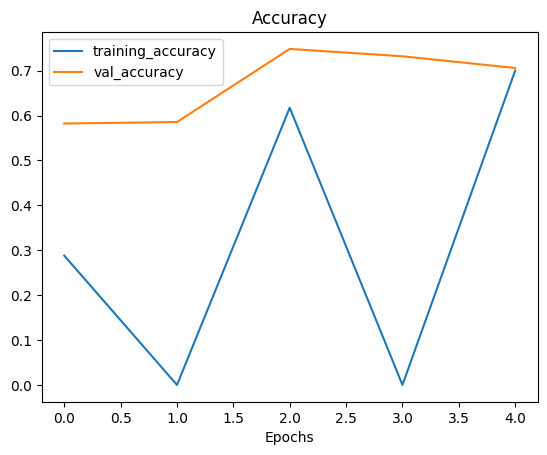

In [39]:
# Plot model loss curves
plot_loss_curves(history_10_percent_data_aug)

### Loading in checkpointed weights

Loading in checkpointed weights returns a model to a specific checkpoint.

In [40]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)

In [41]:
# Evaluate model_2 weights with loaded weigths
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - accuracy: 0.7572 - loss: 0.9763


In [42]:
# If the results form our previously evaluated model_2 match the loaded weigths, everything has worked
results_10_percent_data_aug == loaded_weights_model_results

True

In [43]:
results_10_percent_data_aug

[0.9568334221839905, 0.7644000053405762]

In [44]:
loaded_weights_model_results

[0.9568334221839905, 0.7644000053405762]

In [45]:
# Check to see if loaded model results are very close to our previous non-loaded model results
import numpy as np
np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results))

array([ True,  True])

In [46]:
# Check the difference between the two results
print(np.array(results_10_percent_data_aug) - np.array(loaded_weights_model_results))

[0. 0.]


### Model 3: Fine-tuning an existing model on 10% of the data

> 🔑 **Note:** Fine-tuning usually works best *after* training a feature extraction model for a few epochs with larger amounts of custom data.

In [47]:
# Layers in loaded model
model_2.layers

[<InputLayer name=input_layer, built=True>,
 <Sequential name=data_augmentation, built=True>,
 <Functional name=efficientnetb0, built=True>,
 <GlobalAveragePooling2D name=global_average_pooling_layer, built=True>,
 <Dense name=output_layer, built=True>]

In [48]:
# Are these layers trainable?
for layer in model_2.layers:
  print(layer, layer.trainable)

<InputLayer name=input_layer, built=True> True
<Sequential name=data_augmentation, built=True> True
<Functional name=efficientnetb0, built=True> False
<GlobalAveragePooling2D name=global_average_pooling_layer, built=True> True
<Dense name=output_layer, built=True> True


In [49]:
# What layers are in our base_model (EfficientNetB0) and are they trainable?
for i, layer in enumerate(model_2.layers[2].layers):
  print(layer.name, layer.trainable)

input_layer_3 False
rescaling_4 False
normalization_2 False
rescaling_5 False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False
block1a_activation False
block1a_se_squeeze False
block1a_se_reshape False
block1a_se_reduce False
block1a_se_expand False
block1a_se_excite False
block1a_project_conv False
block1a_project_bn False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False
block2a_dwconv_pad False
block2a_dwconv False
block2a_bn False
block2a_activation False
block2a_se_squeeze False
block2a_se_reshape False
block2a_se_reduce False
block2a_se_expand False
block2a_se_excite False
block2a_project_conv False
block2a_project_bn False
block2b_expand_conv False
block2b_expand_bn False
block2b_expand_activation False
block2b_dwconv False
block2b_bn False
block2b_activation False
block2b_se_squeeze False
block2b_se_reshape False
block2b_se_reduce False
block2b_se_expand False
block2b_se_excite False
bl

In [50]:
# How many trainable variables are in our base model?
print(len(model_2.layers[2].trainable_variables))

0


In [54]:
# To begin fine-tuning, let's start by setting the last 10 layers of our base_model.trainable = True
base_model.trainable = True

# Freeze all layers except for the last 10
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Recompile (we have to recompile our model every time we make a change)
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # when fine-tuning you typically want to lower the learning rate by 10x
                metrics=["accuracy"])

> 🔑 **Note:** When using fine-tuning it's best practice to lower your learning rate by some amount. How much? This is a hyperparameter you can tune, but a good rule of thumb is at least 10x (though different sources will claim other values).

A good resource for information on this is the UMLFit paper: https://arxiv.org/abs/1801.06146

In [55]:
# Check which layers are tunable (trainable)
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer_3 False
1 rescaling_4 False
2 normalization_2 False
3 rescaling_5 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeez

In [58]:
# Now we've unforzen some of the layers closer to the top, how many trainable layers are there?
print(len(model_2.trainable_variables))

12
